In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from os import listdir
from os.path import isfile, isdir
from scipy.stats import ttest_ind
import sys

In [2]:
plt.rcParams.update({'font.size': 13})
protein_name = '1PGB'

In [3]:
def calculate_Haming_distance(sequence_a, sequence_b):
    array_a = np.array(list(sequence_a))
    array_b = np.array(list(sequence_b))
    new_residues_idxs = np.where(array_a != array_b)[0]
    Hamm_distance = len(new_residues_idxs)
    return Hamm_distance

---
### PFAM alignement K-sites combinations

In [4]:
site_weights = np.load('Quench/run/inputs/site_weights.npy')
mask = site_weights == 1.
num_Ksites = mask.sum().astype(int)
d_start = f'results/{protein_name}'

with open(f'Quench/results/{protein_name}/{protein_name}_alignement.txt', 'r') as f:
    lines = f.readlines()
alignement = [line.split('\t')[-1][:-1] for line in lines]
Ksites_alignement = [''.join(np.array(list(sequence))[mask]) for sequence in alignement if not '-' in sequence]
Ksites_alignement, alignement_counts = np.unique(Ksites_alignement, return_counts = True)
wt_index = np.argmax(alignement_counts)

print('PFAM alignement K-sites combinations and frequencies:\n')
for idx, (Ksites, count) in enumerate(zip(Ksites_alignement, alignement_counts)):
    if idx == wt_index: suffix = '(1PGB)'
    else: suffix = ''
    print(f'{Ksites}\t\t{format(100 * count/alignement_counts.sum(), ".1f")}%\t{suffix}')
print()

PFAM alignement K-sites combinations and frequencies:

FGAFFWA		0.9%	
FGAFLWA		1.8%	
FGAFLWG		0.9%	
FIAFAFY		1.8%	
FIAFLYY		1.8%	
LGAFFWA		2.6%	
LGAFGWV		81.6%	(1PGB)
LGAFLWA		6.1%	
LIAFLWA		1.8%	
LIAFLWV		0.9%	



---
### Load replica data

In [25]:
from ReplicaMetropolis.run.utils import load_parameters, load_all

In [26]:
gm_comb = 2

d_start = f'ReplicaMetropolis/results/{protein_name}/gm{gm_comb}'
raw_dirlist = np.array([d for d in listdir(f'{d_start}') if isdir(f'{d_start}/{d}') and (not '.ipynb' in d)])
seeds = np.array([int(d.split('_')[1][1:]) for d in raw_dirlist])
sort_seeds = np.sort(seeds)
sort_dirlist = [raw_dirlist[seeds == seed][0] for seed in sort_seeds]

In [30]:
bad_seeds = [6, 7]
gamma_goal = 'max'

replica_qK, replica_seeds, replica_Ksites, replica_Ksim, replica_sequences, replica_energies = [], [], [], [], [], []
for d, seed in zip(sort_dirlist, sort_seeds):
    if seed in bad_seeds: continue

    actual_d = f'{d_start}/{d}'
    parameters = load_parameters(actual_d)  
    data = load_all(actual_d) 
    
    generations = parameters['generation']
    gammas = parameters['gamma']
    if type(gamma_goal) == str: gamma_goal = gammas.max()
            
    hg_sequences, hg_counts = np.unique(data['sequences'][gammas == gamma_goal].reshape(-1), return_counts = True)
    hg_sequence = hg_sequences[hg_counts.argmax()]
    hg_energy = np.unique(data['energies'][data['sequences'] == hg_sequence])
    assert len(hg_energy) == 1, 'Too many values for hg_energy.'
    hg_energy = hg_energy[0]
    Ksites_hg_sequence = np.array([''.join(np.array(list(hg_sequence))[mask])])[0]
    alignement_distances = []
    for Ksites in Ksites_alignement:
        distance = calculate_Haming_distance(Ksites_hg_sequence, Ksites)
        alignement_distances.append(distance)
    qK = (num_Ksites - np.min(alignement_distances)) / num_Ksites
    most_sim_Ksites = Ksites_alignement[np.argmin(alignement_distances)]

    replica_qK.append(qK)
    replica_seeds.append(seed)
    replica_Ksites.append(Ksites_hg_sequence)
    replica_Ksim.append(most_sim_Ksites)
    replica_sequences.append(hg_sequence)
    replica_energies.append(hg_energy)

replica_data = {
    'qK': np.array(replica_qK),
    'seeds': np.array(replica_seeds),
    'Ksites': np.array(replica_Ksites),
    'Ksim': np.array(replica_Ksim),
    'sequence': np.array(replica_sequences),
    'energy': np.array(replica_energies),
}
replica_data = pd.DataFrame(replica_data)

In [31]:
del replica_qK, replica_seeds, replica_Ksites, replica_Ksim, replica_sequences, replica_energies

In [32]:
replica_data

,qK,seeds,Ksites,Ksim,sequence,energy
0,1.000000,0,LGAFGWV,LGAFGWV,FSYSLVLQTTYGSGNTGVFAPNLTCAQECFFQYARNMGVNGTWSYD...,0.010989
1,0.714286,1,LSAFGFV,LGAFGWV,WRYTLKIENECKSSRASVMAVNHQYARMAFQMYCMWNGVAGKFRYN...,0.025455
2,0.571429,2,FGAIALA,FGAFFWA,LNYRFHLRDPIRSGTAKIQSDSIGEALFLIYWELFCLGIHATLSFD...,0.044118
3,0.428571,3,LSAMGMI,LGAFGWV,FVYRLVVEGPLGNSSNSVVCGTREQAGYIMAMHLMHTGILGEMQYQ...,0.068100
4,0.571429,4,LYAIGMV,LGAFGWV,YWWFLEMHLARGSYLRGFQAPDLREAIERIHFQLRLASIHGAMWYD...,0.078067
5,0.857143,5,LAAFGWV,LGAFGWV,NIFTLEIHTPTGDATSAVTCPTIFEARFTFVQFAVHQGVVGWWSYN...,0.007246
6,1.000000,8,LGAFGWV,LGAFGWV,FVWGLVVHARKHEGSVRVNSANLDEAWIGFKMWAHENEVNGSWKYN...,0.007246
7,0.857143,9,LAAFGWV,LGAFGWV,WKFALKINCEGGTAQATSDYDCVSMAFMQFREIAERYGIVGEWKWS...,0.050725
8,0.714286,10,LAAIGWV,LGAFGWV,CLWGLCIVSNSGNASSTIAARSHQEAFLHIMRLAQSHGIAGDWSYN...,0.055351
9,0.428571,11,MFAIGYV,LGAFGWV,YMYQMIIHTRKQNFSCSFDCDTLLEALKHINHFLMQQHVWGSYTYC...,0.040293


---
### Load Quench data

In [33]:
from Quench.run.utils import load_all

In [34]:
d_start = f'Quench/results/{protein_name}'
raw_dirlist = np.array([d for d in listdir(f'{d_start}') if isdir(f'{d_start}/{d}') and (not '.ipynb' in d)])
seeds = np.array([int(d[1:]) for d in raw_dirlist])
sort_seeds = np.sort(seeds)
sort_dirlist = [raw_dirlist[seeds == seed][0] for seed in sort_seeds]

In [35]:
bad_seeds = []

quench_qK, quench_seeds, quench_Ksites, quench_Ksim, quench_sequences, quench_energies = [], [], [], [], [], []
for d, seed in zip(sort_dirlist, sort_seeds):
    if seed in bad_seeds: continue

    actual_d = f'{d_start}/{d}' 
    data, parameters = load_all(actual_d) 
    generations = parameters['generation']

    last_sequence = data['sequences'][-1]
    last_energy = data['energies'][-1]
    Ksites_last_sequence= np.array([''.join(np.array(list(last_sequence))[mask])])[0]
    alignement_distances = []
    for Ksites in Ksites_alignement:
        distance = calculate_Haming_distance(Ksites_last_sequence, Ksites)
        alignement_distances.append(distance)
    qK = (num_Ksites - np.min(alignement_distances)) / num_Ksites
    most_sim_Ksites = Ksites_alignement[np.argmin(alignement_distances)]

    quench_qK.append(qK)
    quench_seeds.append(seed)
    quench_Ksites.append(Ksites_last_sequence)
    quench_Ksim.append(most_sim_Ksites)
    quench_sequences.append(last_sequence)
    quench_energies.append(last_energy)

quench_data = {
    'qK': np.array(quench_qK),
    'seeds': np.array(quench_seeds),
    'Ksites': np.array(quench_Ksites),
    'Ksim': np.array(quench_Ksim),
    'sequence': np.array(quench_sequences),
    'energy': np.array(quench_energies),
}
quench_data = pd.DataFrame(quench_data)

In [36]:
del quench_qK, quench_seeds, quench_Ksites, quench_Ksim, quench_sequences, quench_energies

In [37]:
quench_data

,qK,seeds,Ksites,Ksim,sequence,energy
0,0.285714,-5,CCSLGMV,LGAFGWV,QTFACWILNHQDTCCVTFDAETPHESRANLQSVMMERQMFGIMTYD...,0.072387
1,0.857143,-4,LGAFGWI,LGAFGWV,YPYSLVTHGNDQTGVTSLLAYNLDDAKHIFWLWGLNQRVYGDWECN...,0.072716
2,0.285714,-3,MGCIAIV,LGAFGWV,YKFMMILECTHKQGTHTANCPTQQDCKTYIQWVLRRHRVYASITYN...,0.073383
3,0.285714,-2,FCLVCYC,FIAFLYY,HWYRFVHHGPNHECMGVAQVPHVHWLMNAVEKATKAANIKCKYRWS...,0.073048
4,0.428571,-1,MRCFAFV,FIAFAFY,PLWEMEWHLGGTTRADTLHGRNSSECQSQFKLYAEMSAIEAEFTLD...,0.072716
5,0.428571,0,FMCCGWV,LGAFGWV,IIYVFMIVTPQAKMSCPIMARDLFECLYVCKHFVSTLDIVGDWQWD...,0.071429
6,0.285714,1,FAFFGML,FGAFFWA,IVYSFQIKWHGSVASMEYRTDTFQQFNYFFMHWMRDENVNGSMQYE...,0.072464
7,0.142857,2,CAAISII,FGAFFWA,QSYSCGYHTKHCSAVRQFSVPSWAQAVYTIMQDIVKHEVPSSISYD...,0.073529
8,0.571429,3,LSAFFYV,LGAFFWA,HLFGLEISNCNRWSRHSIQVSDAQQAEFAFRWIAKSAGCHFCYMYN...,0.071942
9,0.285714,4,FALLVFM,FIAFAFY,ETYKFLVLTNKMHAHSTMNASNEKALQHQLYQMAEWMQLNVCFMFN...,0.070111


---
### Replica-Quench comparison

In [38]:
data = pd.concat([replica_data, quench_data], ignore_index = True)
data['simulation type'] = ['replica'] * len(replica_data) + ['quench'] * len(quench_data)

In [39]:
data

,qK,seeds,Ksites,Ksim,sequence,energy,simulation type
0,1.000000,0,LGAFGWV,LGAFGWV,FSYSLVLQTTYGSGNTGVFAPNLTCAQECFFQYARNMGVNGTWSYD...,0.010989,replica
1,0.714286,1,LSAFGFV,LGAFGWV,WRYTLKIENECKSSRASVMAVNHQYARMAFQMYCMWNGVAGKFRYN...,0.025455,replica
2,0.571429,2,FGAIALA,FGAFFWA,LNYRFHLRDPIRSGTAKIQSDSIGEALFLIYWELFCLGIHATLSFD...,0.044118,replica
3,0.428571,3,LSAMGMI,LGAFGWV,FVYRLVVEGPLGNSSNSVVCGTREQAGYIMAMHLMHTGILGEMQYQ...,0.068100,replica
4,0.571429,4,LYAIGMV,LGAFGWV,YWWFLEMHLARGSYLRGFQAPDLREAIERIHFQLRLASIHGAMWYD...,0.078067,replica
5,0.857143,5,LAAFGWV,LGAFGWV,NIFTLEIHTPTGDATSAVTCPTIFEARFTFVQFAVHQGVVGWWSYN...,0.007246,replica
6,1.000000,8,LGAFGWV,LGAFGWV,FVWGLVVHARKHEGSVRVNSANLDEAWIGFKMWAHENEVNGSWKYN...,0.007246,replica
7,0.857143,9,LAAFGWV,LGAFGWV,WKFALKINCEGGTAQATSDYDCVSMAFMQFREIAERYGIVGEWKWS...,0.050725,replica
8,0.714286,10,LAAIGWV,LGAFGWV,CLWGLCIVSNSGNASSTIAARSHQEAFLHIMRLAQSHGIAGDWSYN...,0.055351,replica
9,0.428571,11,MFAIGYV,LGAFGWV,YMYQMIIHTRKQNFSCSFDCDTLLEALKHINHFLMQQHVWGSYTYC...,0.040293,replica


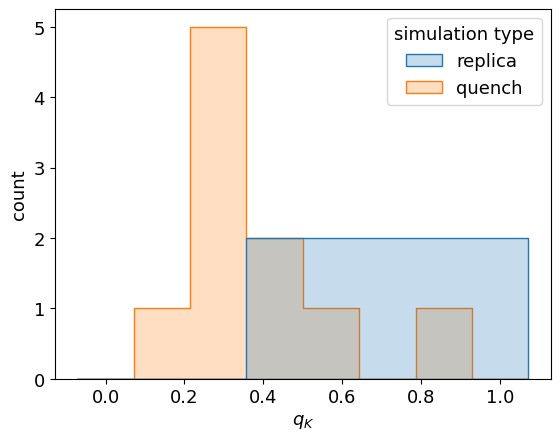

In [40]:
numKsites = 7

fig, ax = plt.subplots()
sns.histplot(
    data = data, 
    x = 'qK',
    bins = np.linspace(0., 1. + 1./numKsites, numKsites + 2) - 1./numKsites/2.,
    hue = 'simulation type',
    element = 'step',
    ax = ax
)
ax.set_ylabel('count')
ax.set_xlabel(r'$q_K$')
plt.savefig(f'plots/Quench_Replica_qK.png', bbox_inches='tight');

In [41]:
ttest = ttest_ind(replica_data['qK'], quench_data['qK'], equal_var = False)
print(f'P-value: {format(ttest[1], ".4f")}')

P-value: 0.0024


In [42]:
print('Means:')
for sim_type in ('replica', 'quench'):
    mean = data.loc[data['simulation type'] == sim_type, 'qK'].mean()
    std = data.loc[data['simulation type'] == sim_type, 'qK'].std()
    print(f"{sim_type}: {format(mean, '.4f')} +/- {format(std, '.4f')}")

Means:
replica: 0.7143 +/- 0.2130
quench: 0.3857 +/- 0.2026


---
### Sequences

In [45]:
print('Replica sequences:')
for iseq, (energy, sequence) in enumerate(zip(replica_data['energy'], replica_data['sequence'])):
    print(f'R{iseq}\t{format(energy, ".3f")}\t{sequence}')

Replica sequences:
R0	0.011	FSYSLVLQTTYGSGNTGVFAPNLTCAQECFFQYARNMGVNGTWSYDDQMQTFTVTT
R1	0.025	WRYTLKIENECKSSRASVMAVNHQYARMAFQMYCMWNGVAGKFRYNKDERTYVVCY
R2	0.044	LNYRFHLRDPIRSGTAKIQSDSIGEALFLIYWELFCLGIHATLSFDNDDETFVARV
R3	0.068	FVYRLVVEGPLGNSSNSVVCGTREQAGYIMAMHLMHTGILGEMQYQRDQNTFIITQ
R4	0.078	YWWFLEMHLARGSYLRGFQAPDLREAIERIHFQLRLASIHGAMWYDQETNLFMVYT
R5	0.007	NIFTLEIHTPTGDATSAVTCPTIFEARFTFVQFAVHQGVVGWWSYNPRKNCFTVKW
R6	0.007	FVWGLVVHARKHEGSVRVNSANLDEAWIGFKMWAHENEVNGSWKYNCHTHVFTVNE
R7	0.051	WKFALKINCEGGTAQATSDYDCVSMAFMQFREIAERYGIVGEWKWSNDSGTWTVWC
R8	0.055	CLWGLCIVSNSGNASSTIAARSHQEAFLHIMRLAQSHGIAGDWSYNHQYNMYTVFT
R9	0.040	YMYQMIIHTRKQNFSCSFDCDTLLEALKHINHFLMQQHVWGSYTYCNYTNTFIVTE


In [46]:
print('Quench sequences:')
for iseq, (energy, sequence) in enumerate(zip(quench_data['energy'], quench_data['sequence'])):
    print(f'Q{iseq}\t{format(energy, ".3f")}\t{sequence}')

Quench sequences:
Q0	0.072	QTFACWILNHQDTCCVTFDAETPHESRANLQSVMMERQMFGIMTYDRMYHTWIVIM
Q1	0.073	YPYSLVTHGNDQTGVTSLLAYNLDDAKHIFWLWGLNQRVYGDWECNEQTMTFTITY
Q2	0.073	YKFMMILECTHKQGTHTANCPTQQDCKTYIQWVLRRHRVYASITYNHNQMNYLVQC
Q3	0.073	HWYRFVHHGPNHECMGVAQVPHVHWLMNAVEKATKAANIKCKYRWSARHRTLWCYT
Q4	0.073	PLWEMEWHLGGTTRADTLHGRNSSECQSQFKLYAEMSAIEAEFTLDLGSNKWTVAG
Q5	0.071	IIYVFMIVTPQAKMSCPIMARDLFECLYVCKHFVSTLDIVGDWQWDHGRNHLQVCV
Q6	0.072	IVYSFQIKWHGSVASMEYRTDTFQQFNYFFMHWMRDENVNGSMQYEQHKNQMTLIV
Q7	0.074	QSYSCGYHTKHCSAVRQFSVPSWAQAVYTIMQDIVKHEVPSSISYDPKEKHFDIRE
Q8	0.072	HLFGLEISNCNRWSRHSIQVSDAQQAEFAFRWIAKSAGCHFCYMYNRGKSEFKVWM
Q9	0.070	ETYKFLVLTNKMHAHSTMNASNEKALQHQLYQMAEWMQLNVCFMFNKDQKQFIMAS
